In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from transformers import AutoProcessor, LlavaForConditionalGeneration

from dataset import VQAv2Eval
# from inference_pipeline import InferencePipeline
# import time
# from scoring_pipeline import ScoringPipeline

from dataset import VQAv2Eval
# import os
from awq.llava_quantizer import LlavaAWQQuantizer
from transformers.models.llava.image_processing_llava import LlavaImageProcessor

/fs/nexus-scratch/vla/micromamba/envs/MMQ_LLAVA/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
device

device(type='cuda')

In [4]:
# VQAv2 dataset paths
ann_root = '/fs/cfar-projects/low-bit-vision/datasets/vqav2/annotations'
q_root = '/fs/cfar-projects/low-bit-vision/datasets/vqav2/questions'
image_root = '/fs/cfar-projects/low-bit-vision/datasets/vqav2/val2014'

llava_prompt = 'USER: <image>\n{}\nAnswer the question using a single word or phrase. ASSISTANT:'

dataset = VQAv2Eval(image_root=image_root,
                    ann_root=ann_root,
                    q_root=q_root,
                    prompt=llava_prompt)

In [5]:
# Load the model
model = LlavaForConditionalGeneration.from_pretrained("llava-hf/llava-1.5-7b-hf", torch_dtype=torch.float16)
processor = AutoProcessor.from_pretrained("llava-hf/llava-1.5-7b-hf", pad_token = '<pad>', use_fast = False)
# need to use this image processor w/ do_pad=True according to "Note regarding reproducing original implementation"
# https://huggingface.co/docs/transformers/en/model_doc/llava
image_processor = LlavaImageProcessor.from_pretrained("llava-hf/llava-1.5-7b-hf",
                                                        do_pad=True)

processor.image_processor = image_processor

model.to(device)

Loading checkpoint shards: 100%|██████████| 3/3 [00:00<00:00, 13.14it/s]


LlavaForConditionalGeneration(
  (vision_tower): CLIPVisionModel(
    (vision_model): CLIPVisionTransformer(
      (embeddings): CLIPVisionEmbeddings(
        (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
        (position_embedding): Embedding(577, 1024)
      )
      (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-23): 24 x CLIPEncoderLayer(
            (self_attn): CLIPSdpaAttention(
              (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): Q

In [ ]:
# FP output
conversation = [
    {
        "role": "user",
        "content": [
            {"type": "image", "url": "https://www.ilankelman.org/stopsigns/australia.jpg"},
            {"type": "text", "text": "What is shown in this image?"},
        ],
    },
]

inputs = processor.apply_chat_template(
    conversation,
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt"
).to(model.device, torch.float16)

with torch.no_grad():
    # Generate
    generate_ids = model.generate(**inputs, max_new_tokens=30)
    
    print(processor.batch_decode(generate_ids, skip_special_tokens=True))

In [6]:
config = {}

# config['vision_layers'] = {
#     'self_attn':16,
#     'mlp': 16
# }

config['llm_layers'] = {
    'self_attn': 4,
    'mlp': 4
}

config

{'llm_layers': {'self_attn': 4, 'mlp': 4}}

In [7]:
quantizer = LlavaAWQQuantizer(model, device, processor, dataset, config)

In [8]:
quantizer.n_samples = 128

In [9]:
print(quantizer.n_samples)

128


In [10]:
model.to(device)
quantizer.quantize()

layer_groups: {'llm_layers': ModuleList(
  (0-31): 32 x LlamaDecoderLayer(
    (self_attn): LlamaAttention(
      (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
      (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
      (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
      (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
    )
    (mlp): LlamaMLP(
      (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
      (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
      (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
      (act_fn): SiLU()
    )
    (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
    (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
  )
)}
Calibration set size: 128


Quantizing llm_layers: 100%|██████████| 32/32 [39:38<00:00, 74.34s/it]


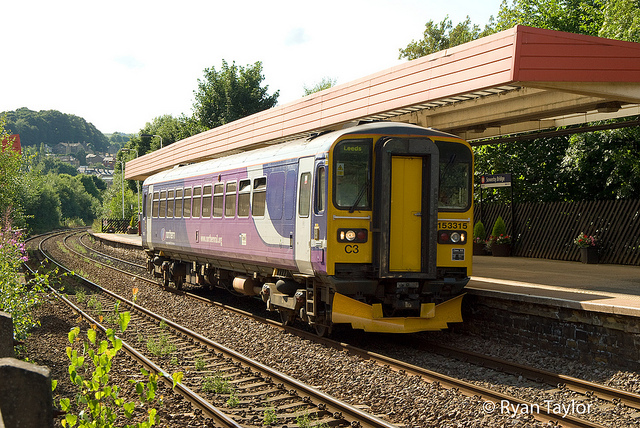

In [11]:
dataset[100]['image']

In [12]:
img = dataset[100]['image']
prompt = 'USER: <image>\n' + dataset.qa_pairs[100]['question'] + '\nAnswer the question using a single word or phrase. ASSISTANT:'

print(prompt)

USER: <image>
What is the background metal structure?
Answer the question using a single word or phrase. ASSISTANT:


In [13]:
model = model.to('cuda')
samples = processor(images = [img],
                     text=[prompt],
                     return_tensors='pt',
                     padding=True).to(model.device)

samples.keys()

dict_keys(['input_ids', 'attention_mask', 'pixel_values'])

In [14]:
# Generate
# generate_ids = model.generate(**inputs, max_new_tokens=30)
generate_ids = model.generate(**samples)
processor.batch_decode(generate_ids, skip_special_tokens=True)

['USER: \nWhat is the background metal structure?\nAnswer the question using a single word or phrase. ASSISTANT:49444440404040000000']

In [15]:
from torch.utils.data import DataLoader
from inference_pipeline import InferencePipeline

dataset.set_max_samples(10)

dataloader = DataLoader(dataset,
                        batch_size=16,
                        num_workers=1,
                        pin_memory=False,
                        shuffle=False,
                        collate_fn = dataset.collater)

inferencer = InferencePipeline(model, device, processor)

# set this according to huggingface usage tips: https://huggingface.co/docs/transformers/en/model_doc/llava
processor.tokenizer.padding_side = "left"
processor_kwargs = dict(padding=True)

# greedy decoding
generate_kwargs = {
    'num_beams': 1,
    'do_sample': False
}

results = inferencer.run_inference(
    dataloader,
    task = 'vqav2',
    processor_kwargs = processor_kwargs,
    generate_kwargs = generate_kwargs
)

100%|██████████| 1/1 [00:02<00:00,  2.59s/it]


In [16]:
results

[{'question_id': 262148000,
  'answer': 'USER: \nWhere is he looking?\nAnswer the question using a single word or phrase. ASSISTANT:44444444444444444444'},
 {'question_id': 262148001,
  'answer': 'USER: \nWhat are the people in the background doing?\nAnswer the question using a single word or phrase. ASSISTANT:44444444444444444444'},
 {'question_id': 262148002,
  'answer': 'USER: \nWhat is he on top of?\nAnswer the question using a single word or phrase. ASSISTANT:44444444444444444444'},
 {'question_id': 393225000,
  'answer': 'USER: \nWhat website copyrighted the picture?\nAnswer the question using a single word or phrase. ASSISTANT:44444444444444444444'},
 {'question_id': 393225001,
  'answer': 'USER: \nIs this a creamy soup?\nAnswer the question using a single word or phrase. ASSISTANT:44444444444444444444'},
 {'question_id': 393225002,
  'answer': 'USER: \nIs this rice noodle soup?\nAnswer the question using a single word or phrase. ASSISTANT:44444444444444444444'},
 {'question_id'

In [29]:
results

[{'question_id': 262148000,
  'answer': 'USER: \nWhere is he looking?\nAnswer the question using a single word or phrase. ASSISTANT: Down'},
 {'question_id': 262148001,
  'answer': 'USER: \nWhat are the people in the background doing?\nAnswer the question using a single word or phrase. ASSISTANT: Watching'},
 {'question_id': 262148002,
  'answer': 'USER: \nWhat is he on top of?\nAnswer the question using a single word or phrase. ASSISTANT: Table'},
 {'question_id': 393225000,
  'answer': 'USER: \nWhat website copyrighted the picture?\nAnswer the question using a single word or phrase. ASSISTANT: Foodiebakercom'},
 {'question_id': 393225001,
  'answer': 'USER: \nIs this a creamy soup?\nAnswer the question using a single word or phrase. ASSISTANT: Yes'},
 {'question_id': 393225002,
  'answer': 'USER: \nIs this rice noodle soup?\nAnswer the question using a single word or phrase. ASSISTANT: Yes'},
 {'question_id': 393225003,
  'answer': 'USER: \nWhat is to the right of the soup?\nAnswer t